**Задание:**

Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

In [13]:
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
conn = psycopg2.connect(
 host="158.160.52.106",
 port=5432,
 database="postgres",
 user="student",
 password="JvLda93aA",
)

In [27]:
data = pd.read_sql(
            """SELECT
                  c.client_rk
                  ,c.visit_dttm
                  ,acc.account_rk
                  ,app.application_rk
                  ,g.game_flg
              FROM msu_analytics.client c
                  LEFT JOIN msu_analytics.account acc
                    ON c.client_rk = acc.client_rk 
                  LEFT JOIN msu_analytics.application app
                    ON acc.account_rk = app.account_rk
                  LEFT JOIN msu_analytics.game g
                    ON app.game_rk = g.game_rk """
            , conn)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [29]:
data.loc[data['game_flg'] == 0, 'game_flg'] = None

In [30]:
data['visit_dttm'] = data['visit_dttm'].apply(
    lambda x: x.replace(hour = 0, minute = 0, second = 0, microsecond = 0))

# Конверсии по неделям

In [31]:
max(data['visit_dttm']) - min(data['visit_dttm'])

Timedelta('154 days 00:00:00')

In [32]:
n_weeks = 154 // 7

In [33]:
weeks = []
n_clients = []
n_registrations = []
n_applications = []
n_games = []

date = min(data['visit_dttm'])
for i in range(n_weeks):
  week = pd.date_range(date, periods=7, freq="D")
  start = week[0]
  end = week[6]
  counts = data[(data['visit_dttm'] >= start) & (data['visit_dttm'] < end)].count()

  weeks.append(start.strftime("%y-%m-%d"))
  n_clients.append(counts['client_rk'])
  n_registrations.append(counts['account_rk'] / counts['client_rk'] * 100)
  n_applications.append(counts['application_rk'] / counts['client_rk'] * 100)
  n_games.append(counts['game_flg'] / counts['client_rk'] * 100)
  
  date = end

Text(0, 0.5, 'Количество клиентов, посетивших сайт')

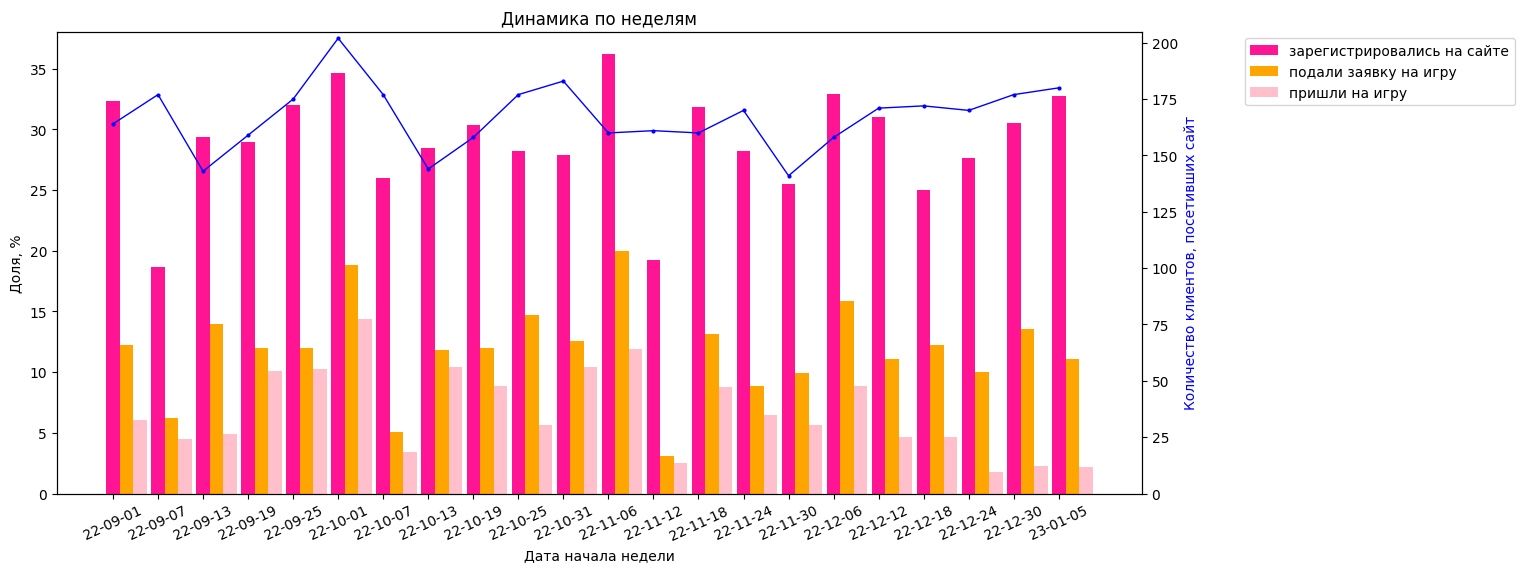

In [34]:
fig, ax = plt.subplots(figsize=(14,6))

bar_width = 0.3
x_pos = np.arange(n_weeks)
ax.bar(x_pos, n_registrations, width=bar_width, color ='deeppink', label='зарегистрировались на сайте')
ax.bar(x_pos+0.3, n_applications, width=bar_width, color ='orange', label='подали заявку на игру')
ax.bar(x_pos+0.6, n_games, width=bar_width, color ='pink', label='пришли на игру')

ax.set_title('Динамика по неделям')
ax.set_xlabel('Дата начала недели')
ax.set_xticks(x_pos, weeks, rotation=25)
ax.set_ylabel('Доля, %')
ax.legend(bbox_to_anchor=(1.35,1))

ax2 = ax.twinx()

ax2.plot(weeks, n_clients, color='blue', linewidth=1, marker='o', markersize=2)
ax2.set_ylim([0, 205])
ax2.set_ylabel('Количество клиентов, посетивших сайт', color='blue')

# Конверсии по месяцам

In [35]:
min(data['visit_dttm'])

Timestamp('2022-09-01 00:00:00')

In [36]:
max(data['visit_dttm'])

Timestamp('2023-02-02 00:00:00')

In [37]:
n_months = 6
months = ['2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01','2023-01-01', '2023-02-01']
n_clients = []
n_registrations = []
n_applications = []
n_games = []

for i in range(n_months):
  start = months[i]
  if (i == 5):
    end = '2023-03-01'
  else:
    end = months[i + 1]

  counts = data[(data['visit_dttm'] >= start) & (data['visit_dttm'] < end)].count()
  n_clients.append(counts['client_rk'])
  n_registrations.append(counts['account_rk'] / counts['client_rk'] * 100)
  n_applications.append(counts['application_rk'] / counts['client_rk'] * 100)
  n_games.append(counts['game_flg'] / counts['client_rk'] * 100)

Text(0, 0.5, 'Количество клиентов, посетивших сайт')

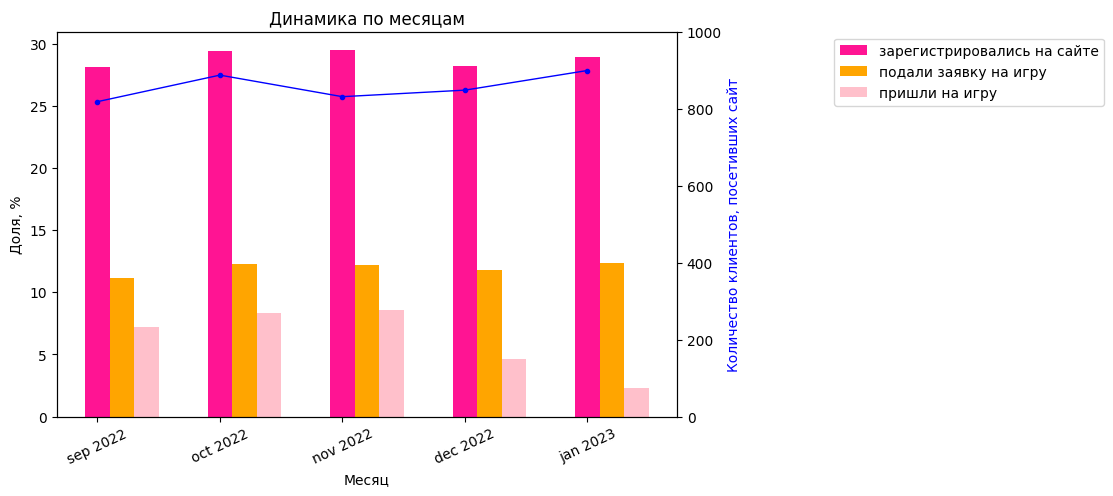

In [38]:
months = ['sep 2022', 'oct 2022', 'nov 2022', 'dec 2022', 'jan 2023', 'feb 2023']
fig, ax = plt.subplots(figsize=(8,5))

bar_width = 0.2
x_pos = np.arange(n_months - 1)
ax.bar(x_pos, n_registrations[:5], width=bar_width, color ='deeppink', label='зарегистрировались на сайте')
ax.bar(x_pos+0.2, n_applications[:5], width=bar_width, color ='orange', label='подали заявку на игру')
ax.bar(x_pos+0.4, n_games[:5], width=bar_width, color ='pink', label='пришли на игру')

ax.set_title('Динамика по месяцам')
ax.set_xlabel('Месяц')
ax.set_xticks(x_pos, months[:5], rotation=25)
ax.set_ylabel('Доля, %')
ax.legend(bbox_to_anchor=(1.7,1))

ax2 = ax.twinx()

ax2.plot(months[:5], n_clients[:5], color='blue', linewidth=1, marker='o', markersize=3)
ax2.set_ylim([0, 1000])
ax2.set_ylabel('Количество клиентов, посетивших сайт', color='blue')